In [1]:
import  numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.quantum_info import SparsePauliOp

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

Para este experimento supangamos un par entrelazado de quibits al queremos realizarle ciertas mediciones. Para cada quibit supondremos dos diferentes orientaciones, para ubicar un polarizador,elegidas por un observador ubicado junto a cada qubit. Para el observador uno dicho polarizador tendra los angulos $\alpha$ y  $\gamma$ respecto a un eje arbitrario. Cada orientación  puede resultar en uno de posibles resultados. Es decir, $\alpha \rightarrow a \pm 1$. Analogamente, para el ángulo $\gamma$, tendra como resultado $c \pm 1$, determinado por las mismas variables ocultas que con la elección de $\alpha$. La situación para el segundo observador es analoga, solo difiere en que este puede medir lo ángulos $\beta$ y $\gamma$ (el mismo ángulo que el primer observador) cuyos resultados en una medición pueden ser $b\pm 1$ y $c\pm 1$ respectivamente.


Los resultados a, b y c deben satisfacer

\begin{equation}
    a(b - c) = 1 - bc
\end{equation}

Dado que cada resultado solo puede ser $\pm1$, la anterior expresión expresión debe satisfacer la siguiente desigualdad

\begin{equation}
    |<ab> - <ac>| \le 1 - <bc>
\end{equation}


Primero vamos generar el estado entrelazado entre un par de qubits descrito por el estado de Bell 
\begin{equation}
    |\phi_{+}> = \frac{|00> + |11>}{\sqrt{2}}
\end{equation}
    
Mediremos entonces el segundo qubit en la orientación $Z$ y $X$, mientras que el primer qubit se medirá en una base ortogonal con un ángulo respecto al segundo qubit. Dicho angulo va a tomar valores entre $0$ y $2\pi$.

Creamos el circuito para realizar las medicones. Además, para evitar crear valios circuitos con la intensión de variar el ángulo entre las bases del obsevador 1 y el 2, definiremos el parámetro theta que variara entre $0$ y $2\pi$.

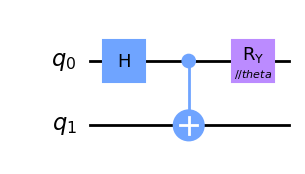

In [2]:
theta = Parameter("$//theta$")

bell_circuits_no_meas = QuantumCircuit(2)
bell_circuits_no_meas.h(0)
bell_circuits_no_meas.cx(0, 1)
bell_circuits_no_meas.ry(theta, 0)
bell_circuits_no_meas.draw("mpl")

In [3]:
number_of_phases = 21
phases = np.linspace(0, 2*np.pi, number_of_phases)
# Las fases deben estar expresadas como una lista
individual_phases = [[ph] for ph in phases]

In [4]:
# Conectar al servicio de qiskit
service = QiskitRuntimeService()#
backend = "ibmq_qasm_simulator"  

Definimos los operadores para los cuales se calcularan los valores esperados que aparecen en la desigualdad. Tendremos una base ortogonal apra cada qubit, dejando que la rotación $Y$ parametrizado para el primer qubit cambia la base de medición respecto al segundo qubit. Luego, se tendran los siguientes observables $ZZ, ZX, XZ$ y $XX$.

In [13]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZX = SparsePauliOp.from_list([("ZX", 1)])
XZ = SparsePauliOp.from_list([("XZ", 1)])

ops = [ZZ, ZX, XZ]
bell_est_sim = []                                                              # guarda el valor de los observables para cada uno de los theta

# Simulator
with Session(service=service, backend=backend):
    estimator = Estimator()                                                     # provee los valores esperados de los observadores definidos  
    for op in ops:
        job = estimator.run(
            circuits=[bell_circuits_no_meas] * len(individual_phases),         # crea un circiito para cada fase
            observables=[op] * len(individual_phases),
                        parameter_values=individual_phases,)
        est_result = job.result()
        bell_est_sim.append(est_result)

Ahora, reemplazamos los valores de los valores esperados en la desigualdad

In [20]:
# <bell> = |<ab> - <ac>| + <bc>
bell_est_sim = np.abs(bell_est_sim[0].values - bell_est_sim[1].values) + bell_est_sim[2].values

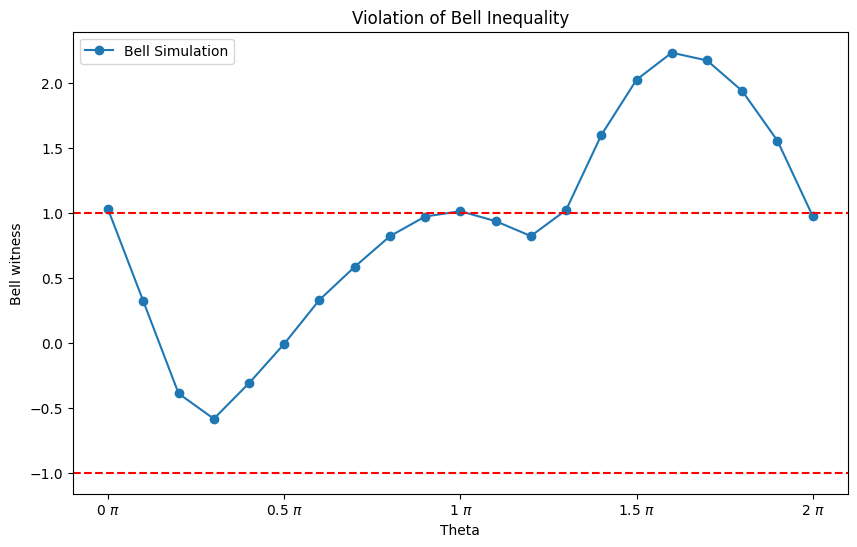

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

fig, ax = plt.subplots(figsize=(10, 6))
# results from a simulator
ax.plot(phases / np.pi, bell_est_sim, "o-", label="Bell Simulation")
# classical bound +-2
ax.axhline(y=1, color="r", linestyle="--")
ax.axhline(y=-1, color="r", linestyle="--")
# # quantum bound, +-2√2
# ax.axhline(y=np.sqrt(2) * 2, color="b", linestyle="-.")
# ax.axhline(y=-np.sqrt(2) * 2, color="b", linestyle="-.")
# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# set title, labels, and legend
plt.title("Violation of Bell Inequality")
plt.xlabel("Theta")
plt.ylabel("Bell witness")
plt.legend()